<a href="https://colab.research.google.com/github/isengu/CycleGAN/blob/main/cyclegan_facades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAU Bahar 2024 Yapay Zeka (BSM310) Ödevi

Ödevde, bulunan örnek bir GAN modelinin farklı bir dataset ile eğitilmesi uygulanmıştır.

### Yapanlar

- İsmail Ensar Gülşen / B201210046 / 1. öğretim A grubu
- Ömer Halil Demirtaş / B201210402 / 1. öğretim A grubu

### Örnek Adresi - CycleGAN

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb#scrollTo=KUgSnmy2nqSP

### Ödevde Kullanılan Dataset - Facades

http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/facades.zip

### Referanslar

1. https://arxiv.org/pdf/1703.10593
2. https://www.tensorflow.org/tutorials/generative/cyclegan
3. https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb
4. https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md

# CycleGAN

CycleGAN, görüntü dönüşümü için kullanılan derin öğrenme tabanlı bir modeldir. Bu model, iki farklı görüntü koleksiyonu arasında dönüşüm yapmak için özellikle popülerdir. Örneğin, atlar ile zebralar arasında bir görüntü dönüşümü gerçekleştirebilir.

Model, iki ana bileşen içerir: jeneratörler ve ayırıcılar (discriminator). Jeneratörler, iki farklı türdeki görüntüler arasında dönüşüm gerçekleştirmek için eğitilirken, ayırıcılar, bu dönüşümün gerçekçiliğini değerlendirir.

Eğitim sırasında, iki ana kayıp (loss) fonksiyonu optimize edilir: ayrıştırma kaybı ve çevrim kaybı. Ayrıştırma kaybı, jeneratörlerin gerçek ve dönüştürülmüş görüntüler arasındaki farkı minimize etmesini sağlar. Çevrim kaybı ise, orijinal görüntülerin çevrim döngüsüyle geri getirilmesini sağlar.

Sonuç olarak, CycleGAN modeli, iki farklı görüntü türü arasında dönüşüm yapmak için güçlü ve verimli bir yöntem sunar. Bu model, fotoğraf dönüşümlerinden sanat eserlerine kadar geniş bir uygulama yelpazesine sahiptir.



## Örnek Model

Bu notebook'da [TenserFlow CycleGAN](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb#scrollTo=KUgSnmy2nqSP) adresinden aldığımız örnek CycleGAN modelini farklı bir dataset ile eğitip çıktılarını inceleyeceğiz.

Aldığımız örnekte at ve zebra resimleriyle eğitilen model, giriş olarak verilen at resimlerini zebraya dönüştürüp çıktı olarak veriyor:

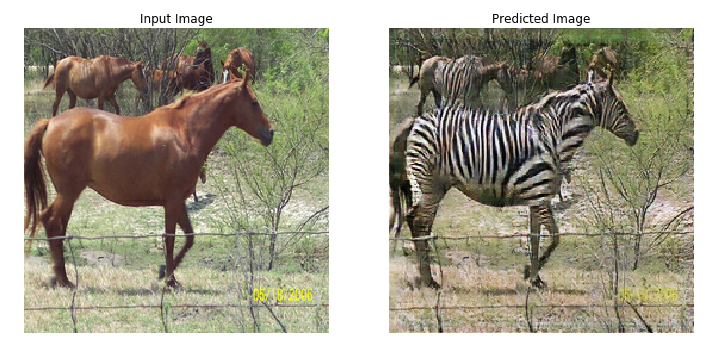

## Dataset Tanıtımı

Bizim kullanacağımız dataset bina silüeti resimleri ve bina silüetine benzeyen çizimleri içeriyor. Eğittiğimiz model bu ikisi arasında bir çevrim işlemi yapacak, giriş olarak çizim verdiğimiz zaman çıkış olarak gerçek bir bina silüetine benzeyen resim üretecek.

Dataset'ten bazı örnekler:

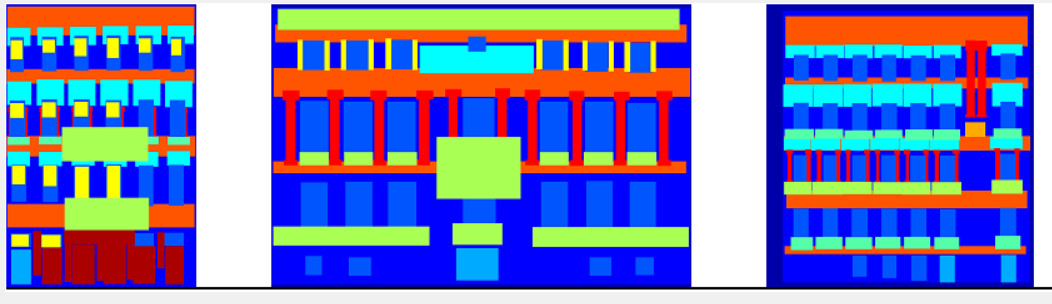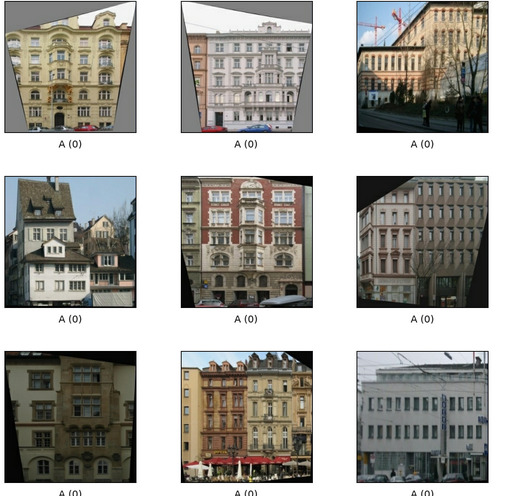

### Kütüphaneler

Gerekli kütüphaneler indirilir ve import edilir.

In [35]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-t9e5s6ws
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-t9e5s6ws
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [36]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

### Data ve Ön Hazırlık

TenserFlow dataset'den data yüklenir ve eğitim öncesi data üzerinde ön hazırlık yapılır.

In [37]:
dataset, metadata = tfds.load('cycle_gan/facades',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainB'], dataset['trainA']
test_horses, test_zebras = dataset['testB'], dataset['testA']

In [38]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [39]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [40]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [41]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [42]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [43]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [44]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [45]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

### Jeneratör ve Ayırıcı

Modelin en önemli kısmı olan jeneratör ve ayırıcıyı Pix2Pix modelinden alıp kullanacağız.

In [46]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

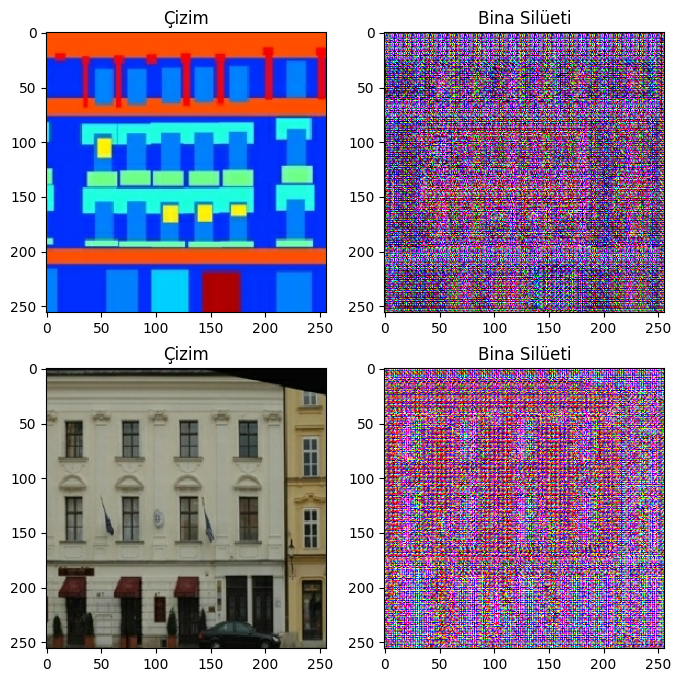

In [47]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Çizim', 'Bina Silüeti', 'Çizim', 'Bina Silüeti']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

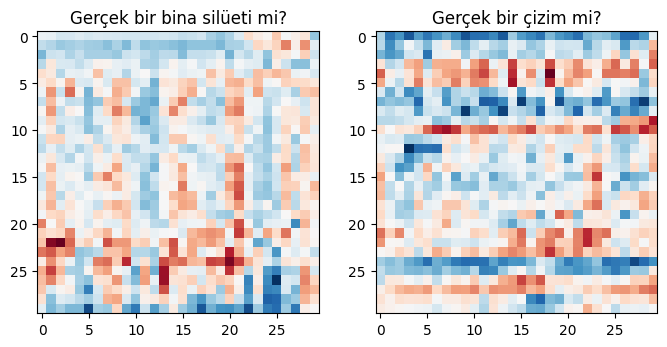

In [48]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Gerçek bir bina silüeti mi?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Gerçek bir çizim mi?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Loss Function

CycleGAN'de eğitim için verilen dataset'de veriler eşli olmadığı için (bir at resmiyle eşleştirilmiş bir zebra resmi yok), eğitim sırasında girdi ve hedef çiftinin anlamlı olma garantisi yoktur. Dolayısıyla, ağın doğru eşleştirmeyi öğrenmesini sağlamak için, çevrim tutarlılık kaybı diye bir kavram ortaya atılmıştır.

Çevrim tutarlılığı, sonucun orijinal girişe yakın olması gerektiği anlamına gelir. Örneğin, bir cümleyi İngilizceden Fransızcaya çevirir ve sonra Fransızcadan tekrar İngilizceye çevirirseniz, sonuç cümlesi orijinal cümle ile aynı olmalıdır.

In [49]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [50]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [51]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [52]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [53]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [54]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoint

Modelin eğitimi için checkpoint oluşturur veya checkpoint var mı diye kontrol eder.

In [55]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


### Eğitim

Eğitim şu 4 aşamadan oluşur:

1. Tahmini al.
2. Farkı hesapla (loss).
3. Backpropation ile hesapla.
4. Hesaplananı uygula.



In [56]:
EPOCHS = 10

In [57]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Giren Görüntü', 'Tahmin Edilen Görüntü']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [58]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

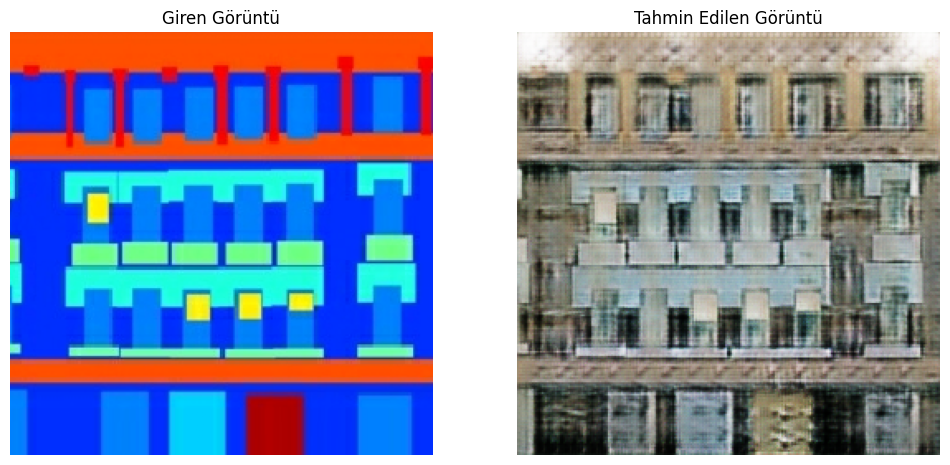

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-4
Time taken for epoch 10 is 187.2788257598877 sec



In [59]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

### Test Dataset ile Eğitilmiş Model Üzerinde Denemeler

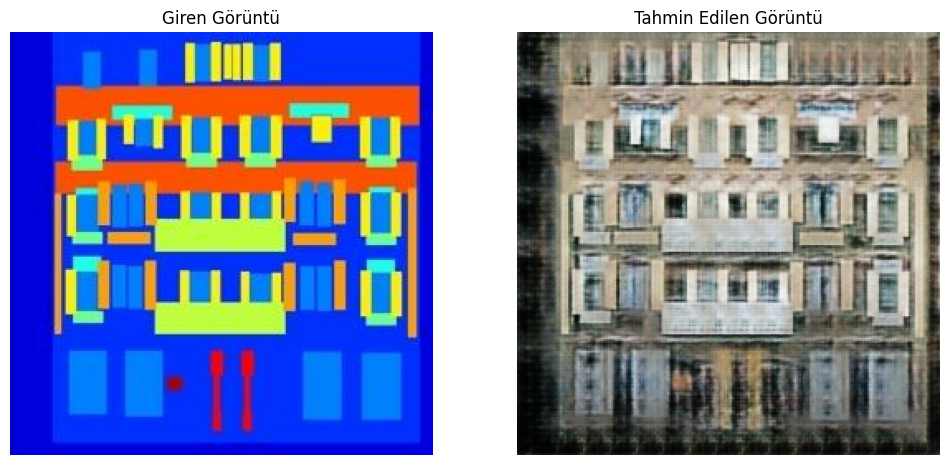

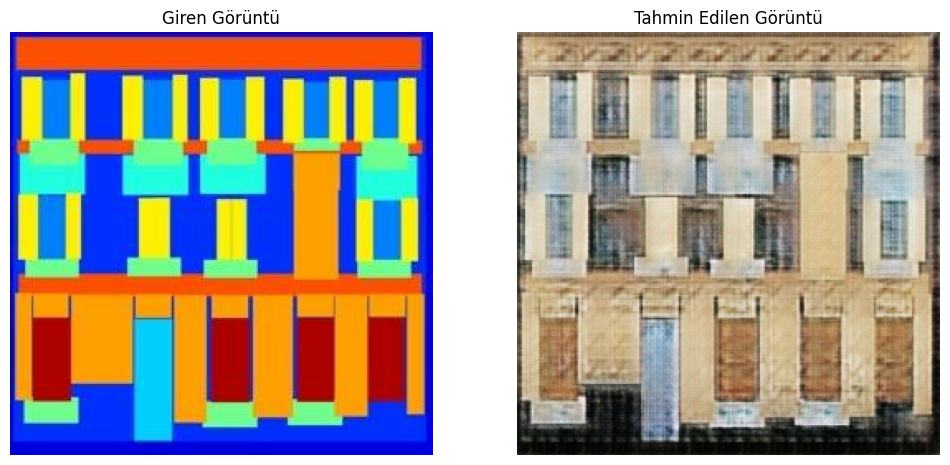

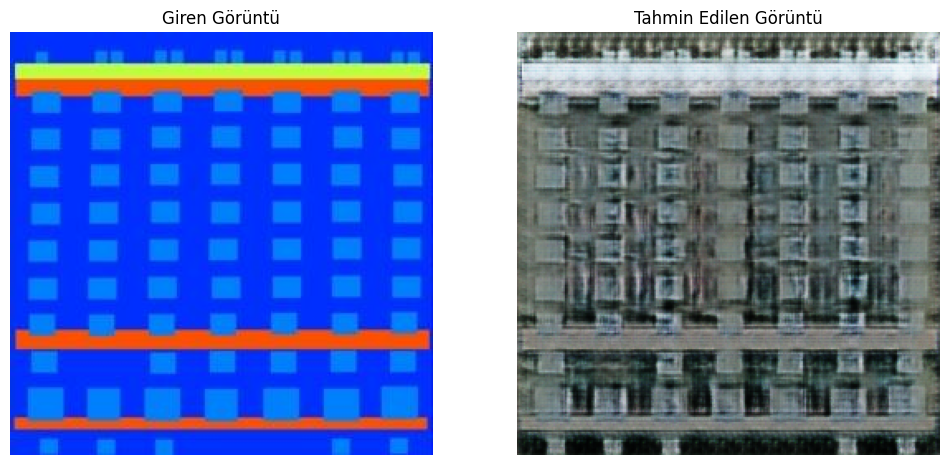

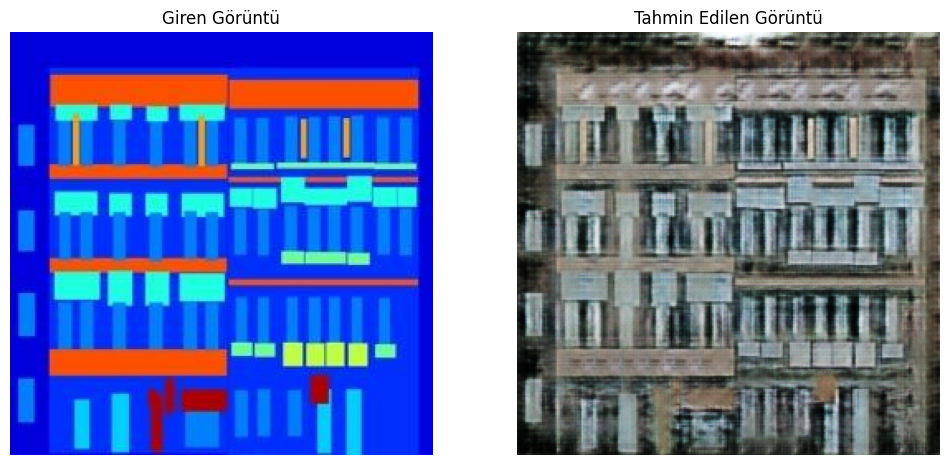

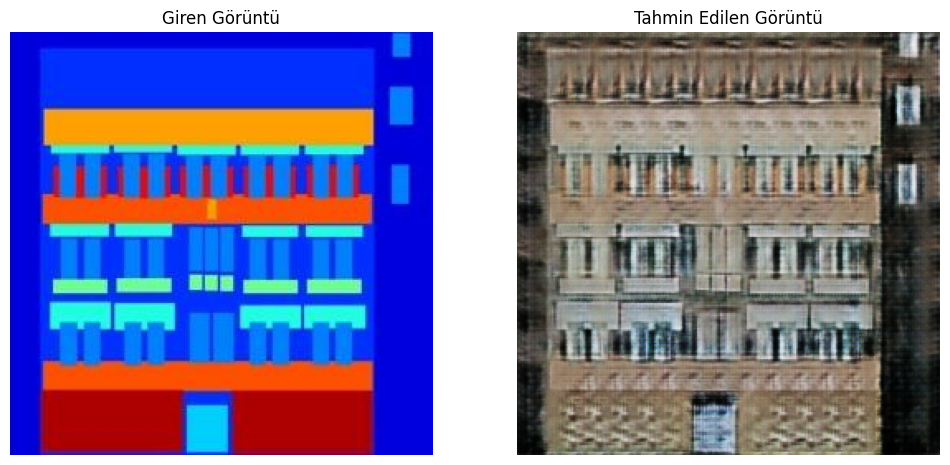

In [60]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)